# Bayesian Networks

This TP provides an excellent opportunity to gain further exposure to relevant topics and applications of Bayesian Networks (diagnosis, prediction, etc.).

Objectives: Students will be able to:
- Create Bayesian Networks.
- Learn Bayesian Networks from real-world problems and datasets.
- Determine inferences from Bayesian Networks.

Technology Requirements:
- Linux (windows user may install virtual machines)
- Python 3.8 or higher (due to pgmpy compatibility)
- Download and install pip and then install pgmpy:
   `$ pip install pgmpy`
- If the previous did not work, this can be done manually after downloading the code source:

```
$ git clone https://github.com/pgmpy/pgmpy
$ cd pgmpy/
$ sudo pip install -r requirements.txt
$ sudo python setup.py install
```


*Note: if you encountered problems installing pip or pgmpy, refer to the pgmpy Installation Page: https://pgmpy.org/started/install.html

In [1]:
#!pip install pgmpy

In [2]:
import pgmpy
import pgmpy.models
import pgmpy.inference
import pgmpy.estimators
import pgmpy.inference

import networkx as nx
import matplotlib.pyplot
import xgboost

import pandas as pd
import time

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from pgmpy.models import BayesianNetwork

/Users/jaheergoulam/PycharmProjects/TP_Machine_Learning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Part 0: Building a model from scratch: Monty Hall Problem

You might know about the famous Monty Hall, or three doors problem (https://en.wikipedia.org/wiki/Monty_Hall_problem). This is a TV game where a contestant $Contestant$ interacts with a host $Host$ to find a price $Price$ hidden behind one of three closed doors. The contestant makes a first choice of one door they would like to open. The host will then help the contestant by opening one of the doors, leaving the contestant to choose again amongst 2 doors. If the chosen door hides the price, the constestant wins.

The host rules for choosing a door to open are:
 - never open the door behind which the price is hidden
 - never open the door chosen by the contestant

A mathematician states: "Selecting in the second step the door that wasn't chosen in the first step, has a 66% probability of granting the price to the contestant". We want to use Bayesian Network modeling to affirm or infirm this statement.

We will model this problem with a three states Bayesian Network.
 - $Contestant$ is a random variable with 3 possible values (the first chosen door by the contestant)
 - $Price$ is a random variable with 3 possible values (the price door)
 - $Host$ is a random variable with 3 possible values (the opened door by the host)

The price is placed before the contestant make its first choice, and the contestant has no indication on its location.


**Question**: From your understanding of the statement, write the independence and conditional independence relations you expect about $Contestant, Price, Host$, in the form "X indep Y" or "X indep Y | Z". (*A relation "X indep Y" means that X and Y value are set independently, without any link or interaction. A relation "X indep Y | Z" means that X and Y have been chosen with respect to a same information which is the value of Z, but other than that, there is no further link between the value of X and Y.*)

**TODO 0.1** Instantiate an object you will name `monty_hall`, from the class `pgmpy.models.BayesianNetwork` (https://pgmpy.org/models/bayesiannetwork.html). Add edges with its `.add_edge` method, corresponding to each edge in the Monty Hall graph.

Run the cell after to visualize the network.

In [3]:
# TODO
monty_hall = BayesianNetwork()

# Add edges representing the conditional dependencies
# Contestant chooses a door independently of everything else
# Host choice depends on both Contestant's choice and the Price door
#"Price" → "Host" : La porte contenant le prix influence la décision de l'animateur.
#"Contestant" → "Host" : Le choix du candidat influence également la décision de l'animateur.
monty_hall.add_edges_from([('Price', 'Host'), ('Contestant', 'Host')])

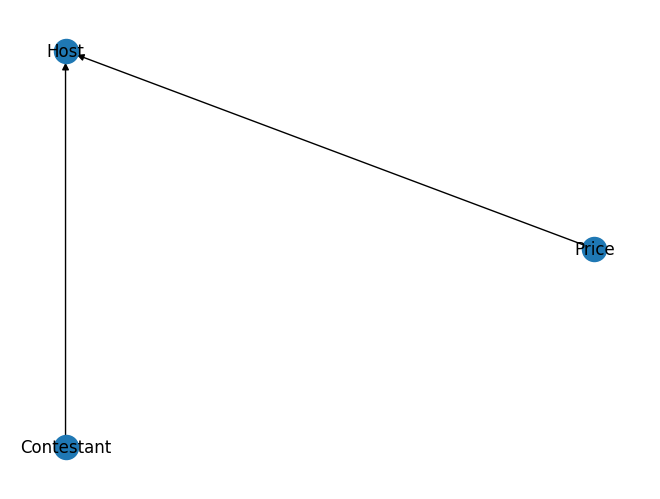

In [4]:
# RUN THIS CELL
def plot_bayesian_network(bn):

    # Convert to a directed graph for visualization
    G = nx.DiGraph(bn.edges())

    # Draw the graph
    nx.draw(G, with_labels=True, pos=nx.circular_layout(G))

plot_bayesian_network(monty_hall)

**TODO 0.2**: BayesianNetwork objects have a method that allows to find automatically the independence relations: `.get_independencies` (https://pgmpy.org/base/base.html). Verify that the relations encoded in the network match your answer to the first question.

If the relations differ, try to explain your reasoning (no point will be deducted for an explained incorrect answer).

In [5]:
# TODO
independencies = monty_hall.get_independencies()
print(independencies)

(Price ⟂ Contestant)
(Contestant ⟂ Price)


Since we have specified the structure of the bayesian network in `monty_hall`, we must now provide the conditional probability distribution.

We assume that both $Contestant$ and $Price$ are chosen randomly (with probability uniformly $\frac13$).

**TODO 0.3** Use `pgmpy.factors.discrete.CPD.TabularCPD` (https://pgmpy.org/factors/discrete.html) to specify the conditional probability distribution of $Contestant$ and of $Price$. Name the TabularCPD of "Contestant" as `cpd_c` and "Price" as `cpd_p`.

Hint: a coin toss can be modeled by `TabularCPD("coin_toss", 2, [[0.5], [0.5]])`

The name of each variable (in first argument) must be identical to the corresponding node in the BayesianNetwork graph `montly_hall`.

In [6]:
# TODO
from pgmpy.factors.discrete import TabularCPD

cpd_c = TabularCPD(variable='Contestant', variable_card=3, values=[[1/3], [1/3], [1/3]])

cpd_p = TabularCPD(variable='Price', variable_card=3, values=[[1/3], [1/3], [1/3]])

monty_hall.add_cpds(cpd_c, cpd_p)


Run the following cell.

In [7]:
# RUN THIS CELL

cpd_h = pgmpy.factors.discrete.CPD.TabularCPD("Host",3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],  #Host=0
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],  #Host=1
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],  #Host=2
    ],
    evidence=["Contestant", "Price"],
    evidence_card=[3, 3])

cpd_h._truncate_strtable = lambda x: x  # prevents table truncating
print(cpd_h)

+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Contestant | Contestant(0) | Contestant(0) | Contestant(0) | Contestant(1) | Contestant(1) | Contestant(1) | Contestant(2) | Contestant(2) | Contestant(2) |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Price      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      | Price(0)      | Price(1)      | Price(2)      |
+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
| Host(0)    | 0.0           | 0.0           | 0.0           | 0.0           | 0.5           | 1.0           | 0.0           | 1.0           | 0.5           |
+------------+---------------+---------------+

**Question**: From the table, what is the value of $\mathbb{P}(Host=0 | Contestant=1, Price=2)$? How do you interpret this value with respect to the problem setting?

    P(Host=0∣Contestant=1,Price=2)=1.0. Cela signifie que lorsque le candidat choisit la porte 1 et que le prix est derrière la porte 2, l'animateur ouvrira toujours la porte 0 avec une probabilité de 1.

**Question**: How many numerical parameters in total were created to build this Bayesian Network? How many would be needed to create the entire joint probability table of $\mathbb{P}(Contestant, Price, Host)$?
 
    Le réseau bayésien a besoin de 22 paramètres pour être construit. Pour créer la table de probabilité conjointe complète P(Contestant,Price,Host), il faudrait 26 paramètres.
    2 paramètres pour le prix,
    2 paramètres pour le candidat,
    18 paramètres pour l'animateur.
    Ainsi, le nombre total de paramètres numériques est : 
    2+2+18=22

Run the following cell to add the probability tables to the `monty_hall` object.

In [8]:
# RUN THIS CELL

# We now add the conditional probability distributions (cpd) to the bayesian network.

monty_hall.add_cpds(cpd_c, cpd_p, cpd_h)

# Verify that the model is correctly specified

assert monty_hall.check_model()

If the previous cell throws an error, you may have mispecified either the monty_hall graph (todo 0.1) or the CPD of $Contestant$ and $Price$ (todo 0.3).

You can check how `check_model` verifies the BayesianNetwork in its documentation (https://pgmpy.org/models/bayesiannetwork.html)

### Application

Suppose that you, as a contestant, have chosen $Contestant=0$ as your first guess.

The host might open door $Host=1$, or $Host=2$ as a result (but never door $0$ as it was chosen by the contestant).

**TODO 0.4** Using `pgmpy.inference.ExactInference.VariableElimination` (https://pgmpy.org/exact_infer/ve.html), compute the exact conditional probability distribution of $\mathbb{P}(Price|Contestant=0,Host=1)$ and $\mathbb{P}(Price|Contestant=0,Host=2)$.

Once a VariableElimination object has been set, you can use the class method `VariableElimination.query` with adequate `variables` and `evidence` parameters. The remaining arguments can be set to their default values.

In [9]:
inference = pgmpy.inference.ExactInference.VariableElimination(monty_hall)

# TODO

from pgmpy.inference import VariableElimination

inference = VariableElimination(monty_hall)

result_price_given_host1 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 1})

result_price_given_host2 = inference.query(variables=['Price'], evidence={'Contestant': 0, 'Host': 2})


print("P(Price | Contestant=0, Host=1):")
print(result_price_given_host1)

print("\nP(Price | Contestant=0, Host=2):")
print(result_price_given_host2)


P(Price | Contestant=0, Host=1):
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.0000 |
+----------+--------------+
| Price(2) |       0.6667 |
+----------+--------------+

P(Price | Contestant=0, Host=2):
+----------+--------------+
| Price    |   phi(Price) |
+==========+==============+
| Price(0) |       0.3333 |
+----------+--------------+
| Price(1) |       0.6667 |
+----------+--------------+
| Price(2) |       0.0000 |
+----------+--------------+


**Question**: According to the two result tables, should you maintain your choice of door $Contestant=0$, or select the remaining door?

Dans les deux cas, la probabilité que le prix soit derrière la porte 0 (le choix initial du candidat) est seulement de 0.3333, tandis que la probabilité qu'il soit derrière l'autre porte non ouverte est de 0.6667.

Il est donc préférable de changer de porte et de choisir la porte restante (soit la porte 1, soit la porte 2, selon celle que l'animateur n'a pas ouverte), car la probabilité que le prix soit derrière cette porte est plus élevée (0.6667) que celle qu'il soit derrière la porte initialement choisie (0.3333).



**Question**: Even though the contestant final choice has one of two doors, why are the probability of success not (0.5, 0.5)?

Au départ, le candidat a 1/3 de chance de choisir la porte avec le prix et 2/3 de chance de choisir une mauvaise porte.
L'animateur sait où se trouve le prix et ouvre toujours une porte qui ne contient pas le prix.
Si le candidat choisit initialement la mauvaise porte (ce qui arrive 2 fois sur 3), la porte restante contiendra toujours le prix, ce qui conduit à une probabilité plus élevée (2/3) de gagner en changeant de porte.

## Part 1: Bayesian Modeling of a credit risk dataset

This part is dedicated to learning a Bayesian model (graph and distribution) to model Credit risk in Germany. In this part, we will not specify the structure by hand, instead it will be learned from the data.

We will see how to:
 - open and inspect a dataset as a DataFrame
 - handle missing values with and without domain knowledge
 - apply binning to variables with lots of possible values with and without domain knowledge
 - separate data into training and validation sets

First, run the following cell to open the data in the form of a `pandas.DataFrame`.

In [10]:
german_credit = pd.read_csv("https://raw.githubusercontent.com/vidhi-chugh/tds_articles/master/pgmpy_WICDS/german_credit.csv")
german_credit
#print(german_credit)

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


**Question**: What do rows represent? What do columns represent?

     Lignes : Chaque ligne représente un demandeur de crédit.
    Colonnes : Les colonnes correspondent à différentes variables décrivant les demandeurs (données démographiques et financières).

**Question**: What is the name (in the data) of the variable that we want to model?
    
    Risk

**Question**: Are there categorical variables? Continuous? Discrete?

    Discrete :  age, job,Credit and Duration
    Categorical : Gender, Saving, Housing,Purpus and Risk.

### Data Preparation

Before we can use the dataset to model credit risk, we must prepare the data to ensure that it can be used properly. This generally involves three steps.
 - Ensuring that there are no missing values
 - Ensuring that all columns have a type that allows Bayesian Network structure learning and estimation. Specifically, all variables should be discrete, with a sufficiently low number of possible values (https://pgmpy.org/index.html).
 - Separing the data into training and validation sets. The training set is used for structure learning and parameter estimation. The validation set is used to compare different learned models on a prediction task.


We will first handle missing (NaN) values.
- A domain expert tells us that missing values in `"Saving accounts"` are valid. A NaN values show that the credit seeker does not have a saving account. We will replace this value by `"no account"`.

In [11]:
# RUN THIS CELL

# in this cell, german_credit['Saving accounts'].isnull() provides the index table of all null saving account rows.
# then, german_credit.loc[... ,'Saving accounts'] select the cells to be set to the value "no account"

german_credit.loc[german_credit['Saving accounts'].isnull(), 'Saving accounts'] = 'no account'

**TODO 1.1**: Is there any other column with missing values? You can use the `DataFrame.isnull()` method to check if a value is null, and the `DataFrame.sum(axis=0)` method to get the number of nonzero values in each column.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html)
(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)

If there is any missing value remaining, remove the corresponding rows from the DataFrame, using the `.dropna()` method.

(https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)

In [12]:
# TODO

missing_values = german_credit.isnull().sum()

print("Nombre de valeurs manquantes par colonne :")
print(missing_values)

if missing_values.sum() > 0:
    print("Des valeurs manquantes restantes ont été trouvées.")
    
    german_credit = german_credit.dropna()
else:
    print("Aucune valeur manquante restante.")

print("DataFrame après suppression des lignes avec des valeurs manquantes :")
print(german_credit)


Nombre de valeurs manquantes par colonne :
Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64
Aucune valeur manquante restante.
DataFrame après suppression des lignes avec des valeurs manquantes :
     Credit History  Age  Gender  Job Housing Saving accounts  Credit amount  \
0                 4   67    male    2     own      no account           1169   
1                 2   22  female    2     own          little           5951   
2                 4   49    male    1     own          little           2096   
3                 2   45    male    2    free          little           7882   
4                 3   53    male    2    free          little           4870   
..              ...  ...     ...  ...     ...             ...            ...   
995               2   31  female    1     own          little          

Now that we have dealt with missing values, we must ensure that variables are discrete with low number of possible values.
We will arbitrarily say that **above 10 values** is too many.

When a variable has too many values, we must apply binning to it. Binning means grouping together values under new names, into a small number of categories. There are different strategy to binning.
 - A domain expert might create meaningful binning from prior knowledge. For instance, age is usually grouped in 18-25, 26-45, 46-65, 65+ categories.
 - When no prior knowledge is available, a common strategy on ordered data (where a "lesser than" notion makes sense) is to create bins of equal population with ordered values. For instance, age could be grouped in three groups from 18 to 30, 31 to 37, 37+ if each group correspond to roughly the same number of observations (rows).

The following cell iterates over the columns of the dataset, and for each of them, prints the number of unique values contained in the column. It uses `pd.DataFrame.columns` (https://pandas.pydata.org/docs/reference/frame.html) and `pd.Series.unique` (https://pandas.pydata.org/docs/reference/series.html).

In [13]:
# RUN THIS CELL
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 53 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 921 possible values
Variable 'Duration' has 33 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


**Question** Which columns seem to have too many unique values to handle like categorical variables?

    Age avec 53 valeurs, Credit amount a 921 valeurs et Duration a 33 valeurs

**TODO 1.2**: Apply the function `pandas.qcut` (https://pandas.pydata.org/docs/reference/api/pandas.qcut.html), with quantiles `q=[0, .33, .66, 1]` to make three equally populated bins, for `Age`,`Credit amount`, and `Duration`.

You should replace the previous column with the new value: syntax `dataframe[column] = pd.qcut(...)`.

In [14]:
# TODO

german_credit['Age'] = pd.qcut(german_credit['Age'], q=[0, .33, .66, 1], labels=['Young', 'Middle-aged', 'Old'])

german_credit['Credit amount'] = pd.qcut(german_credit['Credit amount'], q=[0, .33, .66, 1], labels=['Low', 'Medium', 'High'])

german_credit['Duration'] = pd.qcut(german_credit['Duration'], q=[0, .33, .66, 1], labels=['Short', 'Medium', 'Long'])

print("DataFrame après le binning :")
print(german_credit[['Age', 'Credit amount', 'Duration']].head())

DataFrame après le binning :
     Age Credit amount Duration
0    Old           Low    Short
1  Young          High     Long
2    Old        Medium    Short
3    Old          High     Long
4    Old          High   Medium


In [15]:
for variable in german_credit.columns:
    print("Variable '{}' has {} possible values".format(variable, len(german_credit[variable].unique())))

Variable 'Credit History' has 5 possible values
Variable 'Age' has 3 possible values
Variable 'Gender' has 2 possible values
Variable 'Job' has 4 possible values
Variable 'Housing' has 3 possible values
Variable 'Saving accounts' has 5 possible values
Variable 'Credit amount' has 3 possible values
Variable 'Duration' has 3 possible values
Variable 'Purpose' has 8 possible values
Variable 'Risk' has 2 possible values


In [16]:
# RUN THIS CELL
# verify that Age, Credit amount and Duration have been correctly prepared
for variable in ["Age", "Credit amount", "Duration"]:
    assert len(german_credit[variable].unique())==3
    print("Variable '{}' has the following list of possible values: {}".format(variable, german_credit[variable].unique()))

Variable 'Age' has the following list of possible values: ['Old', 'Young', 'Middle-aged']
Categories (3, object): ['Young' < 'Middle-aged' < 'Old']
Variable 'Credit amount' has the following list of possible values: ['Low', 'High', 'Medium']
Categories (3, object): ['Low' < 'Medium' < 'High']
Variable 'Duration' has the following list of possible values: ['Short', 'Long', 'Medium']
Categories (3, object): ['Short' < 'Medium' < 'Long']


**TODO 1.3**: To separate our Train/Validation sets, use the method `DataFrame.sample` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) to sample without replacement a fraction 0.9 of the dataset german_credit, called `train_set`. Use the method `DataFrame.drop` (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) with indexes `train_set.index` to create a validation set `val_set`. **IMPORTANT** for reproducibility, make sure to seed your sample selection with parameter `random_state`.

In [17]:
# TODO
# Séparer le jeu de données en train et validation
train_set = german_credit.sample(frac=0.9, random_state=42)  # 90% 
val_set = german_credit.drop(train_set.index)  # 10% 

# Afficher les tailles des jeux de données
print(f"Taille du jeu d'entraînement: {train_set.shape[0]}")
print(f"Taille du jeu de validation: {val_set.shape[0]}")

Taille du jeu d'entraînement: 900
Taille du jeu de validation: 100


In [18]:
# RUN THIS CELL

assert len(train_set)==900
assert len(val_set)==100

We will put aside the validation set for the remainder of part 1 and part 2.

### Model learning

To learn a Bayesian Network structure fitting the data, `pgmpy` provides several algorithms. We will use Hill Climb Search (https://pgmpy.org/structure_estimator/hill.html).
This algorithm:
 - is greedy: a scoring function is optimized by making gradual modification to a Directed Acyclic Graph, until no modification can improve the score (hence, hill-climbing).
 - is heuristic: the scoring function represents some sort of belief of what a best network structure would be. For instance, a best graph would both fit the data well while having a small *description length* (an encoding of this graph should be as small as possible) (BIC score, AIC score). Another best graph concept would rely on fitting the data well while maximizing a probability over a distribution of graphs (K2 score, DBE score...). See http://www.lx.it.pt/~asmc/pub/talks/09-TA/ta_pres.pdf for more details.

**TODO 1.4**: Instanciate `pgmpy.estimators.HillClimbSearch` on the training set. Apply the method `HillClimbSearch.estimate` on the instance, with `k2score`, and otherwise default parameters. Finally, reuse `plot_bayesian_network` defined in part 0 to plot the learned network.


  0%|          | 0/1000000 [00:00<?, ?it/s]

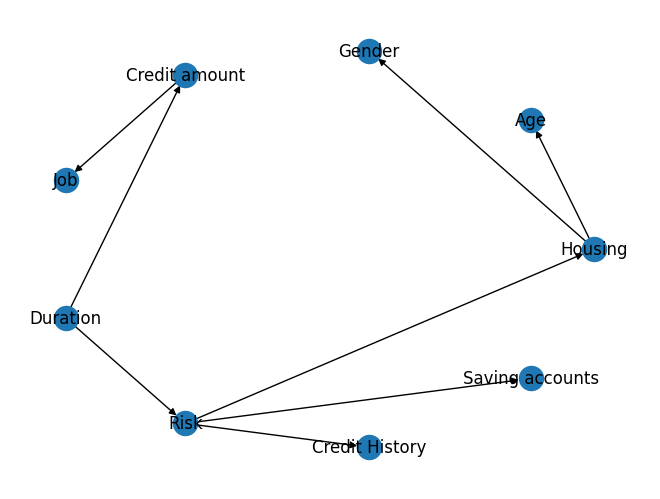

In [19]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt

# Instancier le HillClimbSearch avec les données d'entraînement
hc = HillClimbSearch(train_set)

# Estimer le modèle en utilisant le score K2
meilleur_modele = hc.estimate(scoring_method=BicScore(train_set))

# Créer un modèle bayésien à partir du DAG
bayesian_model = BayesianNetwork(meilleur_modele.edges())

# Tracer le réseau bayésien appris
plot_bayesian_network(bayesian_model)

**TODO 1.5**: The `estimate` method argument `tabu_length` controls how many of the last graph modifications are impossible to modify. Run another graph estimation while setting `tabu_length=1`. Is there any change to the graph?

  0%|          | 0/1000000 [00:00<?, ?it/s]

Modèle avec tabu_length=1 :
Nombres de nœuds dans le modèle initial : ['Housing', 'Age', 'Gender', 'Credit amount', 'Job', 'Duration', 'Risk', 'Credit History', 'Saving accounts']
Nombres de nœuds dans le modèle avec tabu_length=1 : ['Housing', 'Age', 'Gender', 'Credit amount', 'Job', 'Duration', 'Risk', 'Credit History', 'Saving accounts']
Nombres d'arêtes dans le modèle initial : [('Housing', 'Age'), ('Housing', 'Gender'), ('Credit amount', 'Job'), ('Duration', 'Credit amount'), ('Duration', 'Risk'), ('Risk', 'Credit History'), ('Risk', 'Saving accounts'), ('Risk', 'Housing')]
Nombres d'arêtes dans le modèle avec tabu_length=1 : [('Housing', 'Age'), ('Housing', 'Gender'), ('Credit amount', 'Job'), ('Duration', 'Credit amount'), ('Duration', 'Risk'), ('Risk', 'Credit History'), ('Risk', 'Saving accounts'), ('Risk', 'Housing')]


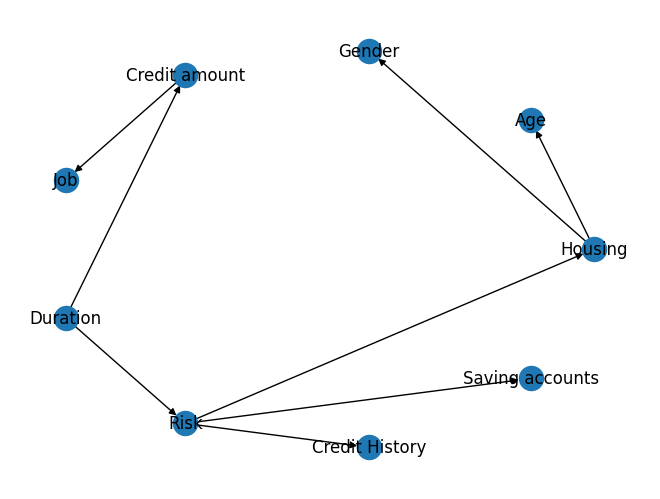

In [20]:
# TODO

# Estimer le modèle avec tabu_length=1
meilleur_modele_tabu = hc.estimate(scoring_method=BicScore(train_set), tabu_length=1)

# Créer un modèle bayésien à partir du DAG avec tabu_length=1
bayesian_model_tabu = BayesianNetwork(meilleur_modele_tabu.edges())

# Tracer le modèle avec tabu_length=1
print("Modèle avec tabu_length=1 :")
plot_bayesian_network(bayesian_model_tabu)

print("Nombres de nœuds dans le modèle initial :", bayesian_model.nodes())
print("Nombres de nœuds dans le modèle avec tabu_length=1 :", bayesian_model_tabu.nodes())
print("Nombres d'arêtes dans le modèle initial :", bayesian_model.edges())
print("Nombres d'arêtes dans le modèle avec tabu_length=1 :", bayesian_model_tabu.edges())

**TODO 1.6**: As mentionned before, different scoring functions encode different beliefs of what an optimal graph would look like. Apply the `estimate` method with `bicscore` scoring method. The BIC (Bayesian Information Criterion) penalizes graphs with a lot of edges, under the belief that the simplest structure is the most likely (Occam's razor https://en.wikipedia.org/wiki/Occam%27s_razor).

  0%|          | 0/1000000 [00:00<?, ?it/s]

Modèle avec le critère BIC :
Nombre de nœuds dans le modèle avec BIC : ['Housing', 'Age', 'Gender', 'Credit amount', 'Job', 'Duration', 'Risk', 'Credit History', 'Saving accounts']
Nombre d'arêtes dans le modèle avec BIC : [('Housing', 'Age'), ('Housing', 'Gender'), ('Credit amount', 'Job'), ('Duration', 'Credit amount'), ('Duration', 'Risk'), ('Risk', 'Credit History'), ('Risk', 'Saving accounts'), ('Risk', 'Housing')]


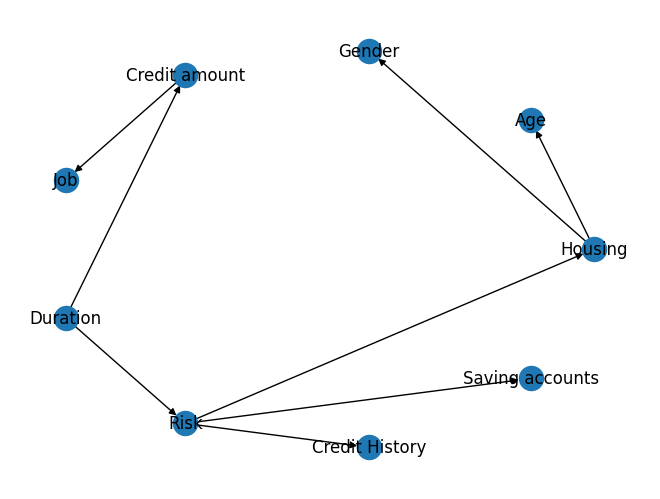

In [21]:
## TODO
bic_model = hc.estimate(scoring_method=BicScore(train_set))

# Créer un modèle bayésien à partir du modèle estimé
bayesian_model_bic = BayesianNetwork(bic_model.edges())
print("Modèle avec le critère BIC :")
plot_bayesian_network(bayesian_model_bic)

# Comparer le modèle obtenu avec BicScore à d'autres modèles (si nécessaire)
print("Nombre de nœuds dans le modèle avec BIC :", bayesian_model_bic.nodes())
print("Nombre d'arêtes dans le modèle avec BIC :", bayesian_model_bic.edges())

**Question** To your opinion, which graph is simpler to interpret?
        
            Le graphe obtenu avec le critère BIC semble être plus simple à interpréter. En effet, le BIC favorise les modèles avec moins d’arêtes, car il pénalise les modèles trop complexes.

**Question** To your opinion, which graph is faster to evaluate?

            Le graphe obtenu avec le BIC devrait également être plus rapide à évaluer. Un modèle avec moins d’arêtes a moins de dépendances entre les variables

We will now use the graph produced by the `bicscore` method. We now need to learn a set of factor functions to model the joint probability distribution.
Precisely, for each node $V$ with parents (in-going edges) $Pa(V)$, we learn $\mathbb{P}(V|Pa(V))$.

The library pgmpy provides several parameter estimation algorithms, each with different particularities. The one we will use is the following:
 - Maximum Likelihood Estimation (https://pgmpy.org/param_estimator/mle.html): estimates joint probabilities by using the frequency/count of each configuration of values. It needs all variables to be observed in the data.

There are other methods, that do not apply to our case:
 - Expectation Maximization (https://pgmpy.org/param_estimator/em.html): Used in the presence of *latent* variables, i.e. variables in the graph for which there is no data. Expectation Maximization does not maximize the likelihood of the joint distribution, but the expectation of this likelihood.
 - Bayesian Estimation (https://pgmpy.org/param_estimator/bayesian_est.html): Used when domain knowledge, or belief, is known beside what is recorded in the data. This knowledge is specified to the algorithm in the form of *priors*. Due to the additional information, parameter estimates typically require less observations than Maximum Likelihood Estimation.




**TODO 1.7**: Apply MLE (https://pgmpy.org/param_estimator/mle.html) with its `.get_parameters()` method to estimate the parameters of the Bayesian Network. Add the parameters to a model object (class `pgmpy.models.BayesianNetwork`) built from the graph structure obtained with bicscore. You will name this model `model`. Use the training data only.

In [22]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Étape 1 : Créer un modèle bayésien à partir du graphe estimé avec BicScore
model = BayesianNetwork(bic_model.edges())

# Étape 2 : Utiliser Maximum Likelihood Estimation (MLE) pour estimer les CPD
mle = MaximumLikelihoodEstimator(model, train_set)

# Appliquer la méthode get_parameters pour obtenir les CPDs
cpds = mle.get_parameters()

# Ajouter manuellement les CPDs au modèle bayésien
for cpd in cpds:
    model.add_cpds(cpd)

# Étape 3 : Vérifier si le modèle est correct après l'ajout des CPDs
try:
    assert model.check_model()
    print("Le modèle est correct avec les CPDs associées.")
except ValueError as e:
    print(f"Erreur dans le modèle : {e}")
    
for param in cpds:
    print(param)


Le modèle est correct avec les CPDs associées.
+---------------+---------------------+---------------------+
| Risk          | Risk(bad)           | Risk(good)          |
+---------------+---------------------+---------------------+
| Housing(free) | 0.15471698113207547 | 0.09291338582677165 |
+---------------+---------------------+---------------------+
| Housing(own)  | 0.6075471698113207  | 0.7543307086614173  |
+---------------+---------------------+---------------------+
| Housing(rent) | 0.23773584905660378 | 0.15275590551181104 |
+---------------+---------------------+---------------------+
+------------------+---------------+--------------+---------------+
| Housing          | Housing(free) | Housing(own) | Housing(rent) |
+------------------+---------------+--------------+---------------+
| Age(Middle-aged) | 0.34          | 0.384375     | 0.21875       |
+------------------+---------------+--------------+---------------+
| Age(Old)         | 0.58          | 0.315625     | 0.1

In [23]:
# RUN THIS CELL
assert model.check_model()

## Part 2: Bayesian Inference

In this part, we will use the previous model to analyse the mechanisms behind Credit Risk attribution by banks.

We will first examine relations between `Gender` and `Risk`.

**TODO 2.1**: Use Variable Elimination to print the joint distribution $\mathbb{P}$(`Gender`,`Risk`). Use Variable Elimination to print the conditional distribution $\mathbb{P}$(`Risk`|`Gender`) for both Gender values.

In [24]:
# TODO
from pgmpy.inference import VariableElimination

# Créer l'objet d'inférence basé sur le modèle bayésien
inference = VariableElimination(model)

# Étape 1 : Calcul de la distribution conjointe P(Gender, Risk)
joint_distribution = inference.query(variables=['Gender', 'Risk'], joint=True)
print("Distribution conjointe P(Gender, Risk) :")
print(joint_distribution)

# Étape 2 : Calcul de la distribution conditionnelle P(Risk | Gender=male)
conditional_risk_given_male = inference.query(variables=['Risk'], evidence={'Gender': 'male'})
print("\nDistribution conditionnelle P(Risk | Gender=male) :")
print(conditional_risk_given_male)

# Étape 3 : Calcul de la distribution conditionnelle P(Risk | Gender=female)
conditional_risk_given_female = inference.query(variables=['Risk'], evidence={'Gender': 'female'})
print("\nDistribution conditionnelle P(Risk | Gender=female) :")
print(conditional_risk_given_female)


Distribution conjointe P(Gender, Risk) :
+----------------+------------+--------------------+
| Gender         | Risk       |   phi(Gender,Risk) |
+================+============+====================+
| Gender(female) | Risk(bad)  |             0.0917 |
+----------------+------------+--------------------+
| Gender(female) | Risk(good) |             0.2083 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(bad)  |             0.2027 |
+----------------+------------+--------------------+
| Gender(male)   | Risk(good) |             0.4973 |
+----------------+------------+--------------------+

Distribution conditionnelle P(Risk | Gender=male) :
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2896 |
+------------+-------------+
| Risk(good) |      0.7104 |
+------------+-------------+

Distribution conditionnelle P(Risk | Gender=female) :
+------------+-------------+
| Risk       |   phi(Risk) |
+======

**Question**: Are gender differences associated to lowered risk? What is hidden in the conditional distribution, that is apparent in the joint distribution? What prior would be needed to deduce the joint distribution $\mathbb{P}$(`Gender`,`Risk`) from the conditional distributions $\mathbb{P}$(`Risk`|`Gender`)?
       
        Distribution conjointe (P(Gender, Risk)) : montre la probabilité combinée des genres et des niveaux de risque, prenant en compte la répartition des genres dans la population.
        Distribution conditionnelle (P(Risk | Gender)) : indique la probabilité de risque pour chaque genre, en ignorant les proportions globales des genres.
        La distribution conjointe inclut les probabilités a priori des genres dans la population, tandis que la distribution conditionnelle se concentre uniquement sur la relation entre le genre et le risque.

**TODO 2.2**: Examine how some of the other variables are associated to varying Risk (using conditional distributions). Write down your conclusions.

In [25]:
# TODO
# Variables d'intérêt
variables_of_interest = ['Credit amount', 'Age', 'Job', 'Credit History']

# Pour chaque variable, nous allons examiner plusieurs valeurs possibles
for variable in variables_of_interest:
    unique_values = german_credit[variable].unique()  # Récupérer les valeurs uniques de chaque variable

    for value in unique_values:
        # Calculer la distribution conditionnelle P(Risk | Variable=value)
        conditional_risk = inference.query(variables=['Risk'], evidence={variable: value})
        print(f"\nDistribution conditionnelle P(Risk | {variable}={value}) :")
        print(conditional_risk)



Distribution conditionnelle P(Risk | Credit amount=Low) :
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2366 |
+------------+-------------+
| Risk(good) |      0.7634 |
+------------+-------------+

Distribution conditionnelle P(Risk | Credit amount=High) :
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3553 |
+------------+-------------+
| Risk(good) |      0.6447 |
+------------+-------------+

Distribution conditionnelle P(Risk | Credit amount=Medium) :
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2869 |
+------------+-------------+
| Risk(good) |      0.7131 |
+------------+-------------+

Distribution conditionnelle P(Risk | Age=Old) :
+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.2976 |
+------------+-------------+
| Risk(good) |  

    Influence du montant de crédit :
        Les individus avec un montant de crédit faible présentent un risque relativement bas (23,66 % de risque mauvais) par rapport à ceux avec un montant de crédit élevé (35,53 % de risque mauvais). Cela suggère que des montants de crédit plus élevés sont associés à une probabilité accrue de défaut.
    
    Impact de l'âge :
        Les distributions de risque sont similaires pour les différentes catégories d'âge. Les jeunes et les personnes âgées affichent des risques légèrement plus élevés (environ 30 %), tandis que les personnes d'âge moyen présentent le risque le plus faible (28,45 %). Cela indique que l'âge n'est pas un facteur déterminant majeur dans l'évaluation du risque.
    
    Relations avec l'emploi :
        Les personnes ayant le Job 1 et Job 0 affichent les meilleures probabilités de risque (environ 27,89 % et 27,94 % de risque mauvais respectivement), tandis que ceux dans Job 3 présentent le risque le plus élevé (32,11 %). Cela suggère que certaines professions peuvent être perçues comme plus sûres que d'autres en termes de comportement de remboursement.
    
    Historique de crédit :
        Un bon historique de crédit (4) est fortement associé à un faible risque (17,31 % de risque mauvais), tandis qu'un historique de crédit très mauvais (0) montre un risque élevé (64,71 % de risque mauvais). Ceci confirme l'idée que l'historique de crédit est un des indicateurs les plus significatifs du risque de crédit.

**BONUS Question** Job categories go from "0 - unskilled" to "3 - highly skilled". Does the risk evolution in function of the Job attribute correspond to your expectations? If not, what could be the reason for the difference?

The Bayesian Network associated to german credit has 9 variables. The previous joint and conditional distribution only involve 2 of them. Therefore, the algorithm has eliminated 7 variables.

The computation time of the inference might change depending on the order in which variables are eliminated. The elimination order is controlled by the parameter `elimination_order` of the `.query` method.

**TODO 2.3** For an identical query of joint probability $\mathbb{P}(Risk, .)$ between the Risk and an arbitrary variable, measure the time spent when given different elimination orders (`greedy`, `MinFill`, `MinNeighbors`, `MinWeight`). You may use `time.time()` to obtain the current time.

In [26]:
# TODO
import time
from pgmpy.inference import VariableElimination

# Créer l'objet d'inférence basé sur le modèle bayésien
inference = VariableElimination(model)

# Choisir une variable arbitraire (exemple : 'Credit amount')
arbitrary_variable = 'Credit amount'

# Liste des méthodes d'élimination à tester
elimination_orders = ['greedy', 'MinFill', 'MinNeighbors', 'MinWeight']

# Mesurer le temps pour chaque méthode d'élimination
for order in elimination_orders:
    start_time = time.time()
    joint_distribution = inference.query(variables=['Risk', arbitrary_variable], elimination_order=order, joint=True)
    elapsed_time = time.time() - start_time
    print(f"Temps pour l'ordre d'élimination {order}: {elapsed_time:.6f} secondes")


Temps pour l'ordre d'élimination greedy: 0.000368 secondes


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Temps pour l'ordre d'élimination MinFill: 0.015919 secondes


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Temps pour l'ordre d'élimination MinNeighbors: 0.021292 secondes


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Temps pour l'ordre d'élimination MinWeight: 0.020559 secondes


The Bayesian Network can help us with *Feature Selection*. The goal of feature selection is to select a subset of variables that contain all the necessary information about `Risk`, i.e., the *Markov Blanket*.

For instance, variable `Job` might have information on `Risk` (i.e., not independent), but this information might already be contained in another variable, making `Job` redundant.

**TODO 2.4** To know which variables can be made independent from `Risk` by conditioning on other variables, it is possible to use the graph structure. Find a Markov Blanket of `Risk`. The method `BayesianNetwork.get_markov_blanket` (https://pgmpy.org/base/base.html) is ready made for this task.

In [27]:
## TODO
# Obtenir le Markov Blanket de la variable 'Risk'
markov_blanket_risk = model.get_markov_blanket('Risk')

# Afficher le Markov Blanket
print("Markov Blanket de 'Risk' :")
print(markov_blanket_risk)


Markov Blanket de 'Risk' :
['Credit History', 'Housing', 'Saving accounts', 'Duration']


**Question** Interpret the markov blanket information: what is a markov blanket and what does it mean regarding how banks attribute credit risk rating?

     Le Markov Blanket d'une variable dans un réseau bayésien est l'ensemble des variables qui rendent cette variable conditionnellement indépendante des autres. Pour Risk, le Markov Blanket comprend :
    
    Housing : Influence du type de logement sur le risque de crédit.
    Saving accounts : Rôle des économies dans la capacité de remboursement.
    Credit History : Indicateur crucial du comportement financier passé.
    Duration : Durée du prêt affectant le niveau de risque.
    Implications pour l'attribution de la note de risque de crédit
    Évaluation ciblée : Les banques peuvent se concentrer sur ces variables pour évaluer plus précisément le risque de crédit.
    Réduction des redondances : Les informations des autres variables, non incluses dans le Markov Blanket, sont considérées comme redondantes.
    Stratégies de crédit : Les banques peuvent ajuster leurs politiques de prêt en fonction des résultats de l'analyse de ces variables.

#### BONUS: causal inference

**This bonus part covers an application of Bayesian Network not covered during the CM. You may go to part 3 directly then come back to it later.**

We will now consider the variable `Job`, for which we observe that Risk is different depending on the category. We can say clearly that Job and Risk aren't **independent**. What we cannot say while looking uniquely at the conditional probability distribution, is whether `Job` influences (is a cause of) `Risk`. Indeed, variables can be associated but not causated.

It is generally difficult to determine causal relationships from observed data. Assuming that causal effects are *linear* (meaning that if `Job` has an influence on `Risk`, then this influence can be correctly modeled by a linear regression model), the causal inference framework (https://pgmpy.org/exact_infer/causal.html) allows to estimate whether two associated variables have a causal influence on each other (Average Treatement Effect https://en.wikipedia.org/wiki/Average_treatment_effect). The question it solves is the following: "if a credit seeker's job category were to increase due to a job change, how much would Risk increase?"

Precisely, the ATE is the difference between the expected Risk when the job stays the same, compared to the expected Risk when the job category increases.

**TODO 2.6**: Apply `pgmpy.inference.CausalInference` with its method `.estimate_ate` on training data, to infer if `Job` has an influence on `Risk`.

In [28]:
#TODO

**Question**: Is Job category causaly linked to Risk?

We now consider the variable `Duration`. We can confirm that it is associated to `Risk`, with higher credit amount related to greater proportion of 'bad' risk. Again, we would like to know if this is a cause-effect relation.

We will now use another way of quantifying causal relationships: *do-calculus* with *counterfactuals*. The question it solves is: "if all credit seekers were to be attributed the same duration by the bank, how would risk be distributed?" If Duration and Risk are not causaly linked, then the resulting distribution of Risk will be identical for all durations.

**TODO 2.7**: Use `CausalInference.query` to estimate the Risk after a do operation on Duration for each category of duration (specify `do={"Duration":value}` for appropriate values).


In [29]:
#TODO

**Question**: Is Duration causaly linked to Risk?

## Part 3: Bayesian models as predictive models

Now that we have learned a model of the training data, we can apply it to validation data to evaluate how it works as a predictive model. We can use Maximum A Posteriori inference, to find out what Risk is most likely considering the values of the other variables. Formally, for a given validation sample $s$ where Risk is removed, we want to estimate $\arg \max \mathbb{P}(Risk | Gender,...,Housing=s)$.

**TODO 3.1**: Use `VariableElimination.map_query` (https://pgmpy.org/exact_infer/ve.html) to predict and store credit risk for each sample in the validation set. You can iterate over samples by using `val_set.to_dict()`, each row being converted to a dictionary. Make sure to not include `Risk` in the evidences.

You will need to store the true risk in a list `y_true` for each sample, and store the corresponding predicted value into a list `y_pred`.

In [30]:
from pgmpy.inference import VariableElimination

# Créer l'objet d'inférence basé sur le modèle bayésien
inference = VariableElimination(model)

# Initialiser les listes pour les valeurs réelles et prédites
y_true = []
y_pred = []

# Itérer sur chaque échantillon du jeu de validation
for sample in val_set.to_dict(orient='records'):
    # Vérifier si 'Risk' est dans l'échantillon
    if 'Risk' in sample:
        # Stocker la valeur réelle de Risk
        y_true.append(sample['Risk'])

        # Créer un dictionnaire d'évidence qui exclut 'Risk' et vérifie la présence des variables dans le modèle
        evidence = {key: value for key, value in sample.items() if key in model.nodes() and key != 'Risk'}

        # Si l'évidence est valide, estimer le risque prédit
        if evidence:
            predicted_risk = inference.map_query(variables=['Risk'], evidence=evidence)

            # Stocker la valeur prédite
            y_pred.append(predicted_risk['Risk'])
        else:
            print("Aucune preuve valide pour l'échantillon :", sample)

# Afficher les résultats
print("Valeurs réelles de Risk :", y_true)
print("Valeurs prédites de Risk :", y_pred)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Valeurs réelles de Risk : ['bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'bad', 'bad', 'good', 'good', 'bad', 'bad', 'good', 'bad', 'bad', 'good', 'bad', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good']
Valeurs prédites de Risk : ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'good', 'good', 

Run the next cell to visualize the classification performance.

Classification accuracy: 0.68


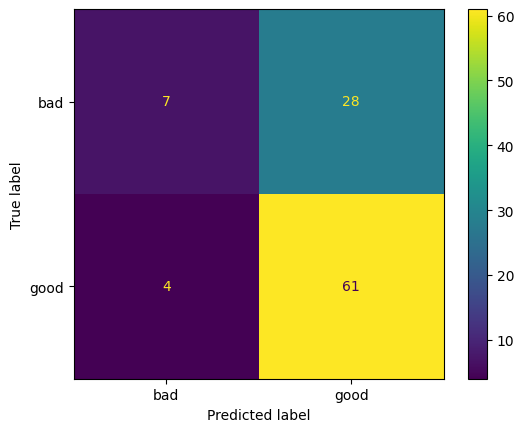

In [31]:
# RUN THIS CELL

print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question** The previous snipet plots a Confusion Matrix. Briefly explain what it means.

     La matrice de confusion permet de visualiser les performances d'un modèle de classification en comparant ses prédictions aux étiquettes réelles. Les quatre quadrants montrent :
    
    Vrais Positifs (good-good) : Prédictions correctes de la classe "good."
    Vrais Négatifs (bad-bad) : Prédictions correctes de la classe "bad."
    Faux Positifs (bad-good) : Prédictions "good" alors que la classe réelle est "bad."
    Faux Négatifs (good-bad) : Prédictions "bad" alors que la classe réelle est "good."
    
**Question** What is the link between the confusion matrix and the accuracy metric?
        
        Précision = (Vrais Positifs + Vrais Négatifs)/Total des prédictions

**Question** What would be False Positive and False Negative in this confusion matrix? Which one would you rather minimize if you were to work for a bank?

        Faux Positifs (FP) : Le modèle prédit un risque "bon" alors qu'il est "mauvais" (28 cas).
        Faux Négatifs (FN) : Le modèle prédit un risque "mauvais" alors qu'il est "bon" (4 cas).
        Pour une banque, il est plus important de minimiser les faux positifs afin d'éviter d'approuver des prêts pour des personnes présentant un mauvais risque, ce qui pourrait entraîner des pertes financières.

We would like to compare the previous map_query predictive model to a standard machine learning model.

We will use XGBoost, one of the main libraries of simple learning models based on "boosting" and specifically "gradient boosting" (https://xgboost.readthedocs.io/en/stable/).


XGBoost is a library that can only manipulate numerical values. Columns "Gender", "Housing", "Saving accounts", "Purpose", and "Risk" contain strings, so we need to transform them. For each of these columns, the next cell creates a new column with suffix "_numerical" (i.e. "Gender_numerical"), where each of the string values is replaced by an integer. This can be done with `.apply`
(https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) and a function, or `.map` (https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) and a dictionary.


In [32]:
# Run this cell.

#method 1
label_mapping = {'good': 0, 'bad': 1}
val_set['Risk_numerical'] = val_set['Risk'].map(label_mapping)
train_set['Risk_numerical'] = train_set['Risk'].map(label_mapping)

#method 2
label_mapping = dict([(value,index) for index,value in enumerate(german_credit["Gender"].unique())])
val_set['Gender_numerical'] = val_set['Gender'].map(label_mapping)
train_set['Gender_numerical'] = train_set['Gender'].map(label_mapping)

#method 3
label_mapping = lambda x: german_credit["Housing"].unique().tolist().index(x)
val_set['Housing_numerical'] = val_set['Housing'].apply(label_mapping)
train_set['Housing_numerical'] = train_set['Housing'].apply(label_mapping)

label_mapping = lambda x: german_credit["Saving accounts"].unique().tolist().index(x)
val_set['Saving accounts_numerical'] = val_set['Saving accounts'].apply(label_mapping)
train_set['Saving accounts_numerical'] = train_set['Saving accounts'].apply(label_mapping)

label_mapping = lambda x: german_credit["Purpose"].unique().tolist().index(x)
val_set['Purpose_numerical'] = val_set['Purpose'].apply(label_mapping)
train_set['Purpose_numerical'] = train_set['Purpose'].apply(label_mapping)

Run the next cell. Its purpose is to make XGBoost and Pandas aware of the categorical nature of some columns.

In [33]:
##  Run this cell.
# Make sure that the column names correspond.

train_set['Purpose_numerical'] = train_set['Purpose_numerical'].astype("category")
val_set['Purpose_numerical'] = val_set['Purpose_numerical'].astype("category")
train_set['Saving accounts_numerical'] = train_set['Saving accounts_numerical'].astype("category")
val_set['Saving accounts_numerical'] = val_set['Saving accounts_numerical'].astype("category")
train_set['Housing_numerical'] = train_set['Housing_numerical'].astype("category")
val_set['Housing_numerical'] = val_set['Housing_numerical'].astype("category")
train_set['Gender_numerical'] = train_set['Gender_numerical'].astype("category")
val_set['Gender_numerical'] = val_set['Gender_numerical'].astype("category")
train_set['Risk_numerical'] = train_set['Risk_numerical'].astype("category")
val_set['Risk_numerical'] = val_set['Risk_numerical'].astype("category")
train_set['Duration'] = train_set['Duration'].astype("category")
val_set['Duration'] = val_set['Duration'].astype("category")
train_set['Age'] = train_set['Age'].astype("category")
val_set['Age'] = val_set['Age'].astype("category")
train_set['Credit amount'] = train_set['Credit amount'].astype("category")
val_set['Credit amount'] = val_set['Credit amount'].astype("category")

**TODO 3.2** In the next cell, create an XGBClassifier model (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) with adequate parameter values. Train (`.fit`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.fit) on `train_set` with the columns `full_variables` to predict "Risk_numerical". Predict (`.predict`, https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier.predict) on the validation set `val_set`, and store the result as `y_pred`.

Hint: for categorical values to be handled, a parameter "enable_categorical" must be set to true at model declaration.

In [34]:
full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]

## WRITE YOUR CODE BELOW
# Import necessary library
from xgboost import XGBClassifier

# Define the model
xgb_model = XGBClassifier(
    enable_categorical=True,  # To handle categorical features
    use_label_encoder=False,  # To avoid warnings about label encoding
    eval_metric='mlogloss',   # Set evaluation metric (multi-class log loss in this case)
    n_estimators=100,         # Number of trees
    max_depth=4,              # Maximum depth of a tree
    learning_rate=0.1,        # Step size shrinkage used in update to prevent overfitting
    random_state=42           # For reproducibility
)

# Define the variables for training (excluding the target variable 'Risk_numerical')
full_variables = ["Purpose_numerical", "Saving accounts_numerical", "Housing_numerical", 
                  "Gender_numerical", "Credit History", "Age", "Job", "Credit amount", "Duration"]

# Train the model on the training set
xgb_model.fit(train_set[full_variables], train_set['Risk_numerical'])

# Predict on the validation set
y_pred = xgb_model.predict(val_set[full_variables])

# Print the predictions
print("Predicted Risk (numerical) values on validation set:", y_pred)


/Users/jaheergoulam/PycharmProjects/TP_Machine_Learning/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicted Risk (numerical) values on validation set: [1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


Run the next cell to evaluate the performance of the model.

Classification accuracy: 0.68


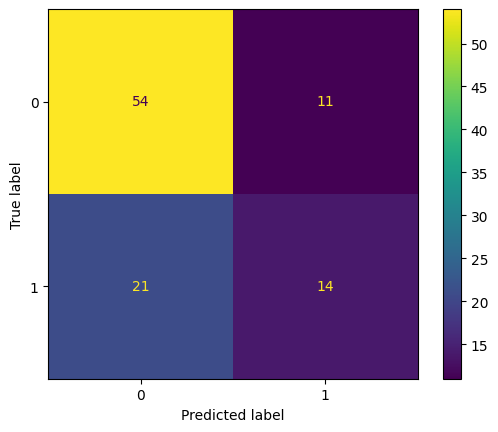

In [35]:
y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**TODO 3.3** Train and evaluate another XGBClassifier, this time with input data restricted to the markov blanket found in TODO 2.4.

In [36]:
## WRITE YOUR CODE BELOW
# Define the XGBClassifier model
xgb_model_mb = XGBClassifier(
    enable_categorical=True,  # To handle categorical features
    use_label_encoder=False,  # To avoid warnings about label encoding
    eval_metric='mlogloss',   # Set evaluation metric (multi-class log loss in this case)
    n_estimators=100,         # Number of trees
    max_depth=4,              # Maximum depth of a tree
    learning_rate=0.1,        # Step size shrinkage used in update to prevent overfitting
    random_state=42           # For reproducibility
)

# Variables from the Markov Blanket of Risk: Housing, Saving accounts, Credit History, and Duration
markov_blanket_variables = ["Housing_numerical", "Saving accounts_numerical", "Credit History", "Duration"]

# Train the model on the training set using only the Markov Blanket variables
xgb_model_mb.fit(train_set[markov_blanket_variables], train_set['Risk_numerical'])

# Predict on the validation set using the same restricted variables
y_pred_mb = xgb_model_mb.predict(val_set[markov_blanket_variables])

# Print the predictions
print("Predicted Risk (numerical) values on validation set with Markov Blanket features:", y_pred_mb)


/Users/jaheergoulam/PycharmProjects/TP_Machine_Learning/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicted Risk (numerical) values on validation set with Markov Blanket features: [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Classification accuracy: 0.68


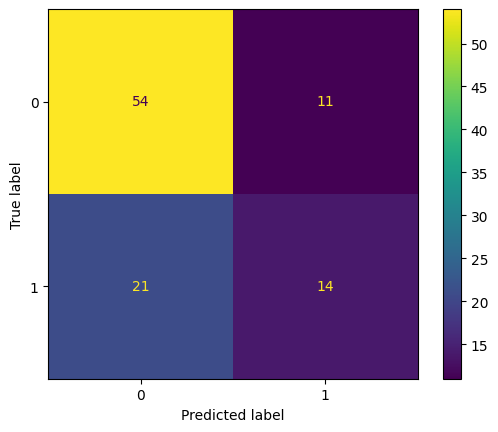

In [37]:
# Run the following

y_true = val_set["Risk_numerical"].values
print("Classification accuracy:" , accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

**Question**: Conclude: did removing columns decrease the information on Risk contained by the dataset? Was this an expected behaviour?

    La performance ne s'est dégradée de manière significative puisque la couverture de Markov contient les principaux prédicteurs.

**Question**: Did removing column increase accuracy? Suggest an explanation why.

    la précision s'améliore après la suppression de variables, cela signifie probablement que les variables supprimées étaient soit non pertinentes, soit nuisibles aux prédictions du modèle. 

**Question**: Conclude on the predictive performance of bayesian modeling versus XGBoost for this dataset.

    Pour ce jeu de données, XGBoost surperforme le modèle bayésien en termes de précision prédictive, car il peut capturer des interactions plus complexes entre les caractéristiques. XGBoost est plus pratique et efficace dans la plupart des tâches d'apprentissage automatique impliquant de grands ensembles de données avec des relations complexes.